In [1]:
import sys
sys.path.append('/cellar/users/hsher/ontoencoder')
from ontoencoder.topology import *
from ontoencoder.util import *
from ontoencoder.model import *
import torch
from collections import OrderedDict, defaultdict


/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


# Load topology

In [24]:
data_root = '/cellar/users/hsher/ontoPrune/data/'
topo = topo_reader(data_root + 'cc_095_drop.topo')
genes = included_genes(topo)

# Load training data

In [3]:
# read processed (lognormalized), labelled single-cell data
adata = tasic_data()
X, gene_name, gene_name_to_id = preprocess_X(adata, genes)

/cellar/users/hsher/miniconda3/envs/ontoencoder/lib/python3.6/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [4]:
X.shape # 1809 cells, 830 genes included in this topology

(1809, 1608)

In [5]:
# prepare y
import pandas as pd
y = pd.get_dummies(adata.obs['class']).values

In [6]:
adata.obs['class'].unique()

[GABA, glutaminergic, non-neuronal, unclassified]
Categories (4, object): [GABA, glutaminergic, non-neuronal, unclassified]

In [7]:
y

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1]], dtype=uint8)

# Split data into training, testing

In [8]:
d = DataLoader(X, y)
X_train, y_train, X_test, y_test = d.split()

In [9]:
y_train.sum(axis = 0)

array([567, 729, 138, 191], dtype=uint64)

In [10]:
y_test.sum(axis = 0)

array([64, 82, 16, 22], dtype=uint64)

# Training

- 6:4--> more representative
- plot 

In [11]:
# record performace
test_lost_profile = []
train_lost_profile = []

# make optimizer
import torch.optim as optim
from torch.nn import functional as F

# initialize model
model = OntoEncoder(topo, gene_name_to_id)

criterion = torch.nn.MSELoss(reduction='mean')
all_params = []
for t in list(topo.keys())[:-1]:
    all_params += list(model.layers[t, 'encode'].parameters()) + list(model.layers[t, 'decode'].parameters())
    
optimizer = optim.Adam(all_params, lr=1e-1)
#optimizer = optim.SGD(all_params, lr=0.1, momentum=0.9)

batch_size = 1000

# train
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0,X_train.shape[0], batch_size): # data
        # get the inputs; data is a list of [inputs, labels]
        x = torch.tensor(X_train[i:i+batch_size,:]).float()
        y = torch.tensor(y_train[i:i+batch_size,:]).float()
                

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = model.forward(x)
        loss = criterion(y_pred, x)
        #if y == 0:
        #    loss = loss * 60 # due to class imbalance punish more
        loss.backward()
        optimizer.step()

        
    print('epoch {}: loss {}'.format(epoch, loss))
    
    train_lost_profile.append(loss)
    
    ### evaluate on test set
    y_test_pred = model.forward(torch.tensor(X_test).float().detach())
    test_loss = criterion(y_test_pred, torch.tensor(X_test).float().detach())
    test_lost_profile.append(test_loss)
        

epoch 0: loss 1.9635769128799438
epoch 1: loss 1.8568822145462036
epoch 2: loss 1.4481792449951172
epoch 3: loss 1.4087454080581665
epoch 4: loss 1.33436119556427
epoch 5: loss 1.2760143280029297
epoch 6: loss 1.2451523542404175
epoch 7: loss 1.228145718574524
epoch 8: loss 1.2151697874069214
epoch 9: loss 1.2046658992767334
epoch 10: loss 1.1986693143844604
epoch 11: loss 1.194368839263916
epoch 12: loss 1.1923145055770874
epoch 13: loss 1.1911442279815674
epoch 14: loss 1.1902580261230469
epoch 15: loss 1.189645528793335
epoch 16: loss 1.1891915798187256
epoch 17: loss 1.1888781785964966
epoch 18: loss 1.1886426210403442
epoch 19: loss 1.1884609460830688
epoch 20: loss 1.188392162322998
epoch 21: loss 1.1882869005203247
epoch 22: loss 1.1882145404815674
epoch 23: loss 1.1881684064865112
epoch 24: loss 1.1881169080734253
epoch 25: loss 1.188059687614441
epoch 26: loss 1.1880015134811401
epoch 27: loss 1.187954068183899
epoch 28: loss 1.1879185438156128
epoch 29: loss 1.187873601913452

In [12]:
test_lost_profile_list = [t.item() for t in test_lost_profile]
train_lost_profile = [t.item() for t in train_lost_profile]

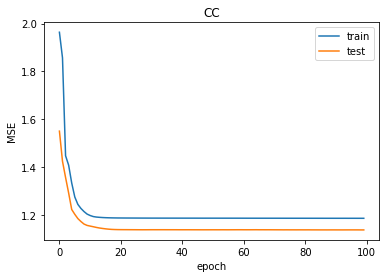

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_lost_profile, label = 'train')
plt.plot(test_lost_profile, label = 'test')
plt.title('CC')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()

# Embed the data

In [14]:
embedding = model.encode(torch.tensor(X).float().detach())

In [15]:
from anndata import AnnData
term_entropy = pd.read_pickle('/cellar/users/hsher/ontoPrune/data/term_entropy.pickle')
def processed_embedding(embedding, model = model, processed = adata):
    ''' make embedding into scanpy object'''
    embedded = AnnData(X = embedding.data.numpy())
    embedded.obs = processed.obs
    
    embedded.var = pd.DataFrame(index = model.topo[model.root]['TERMS'])
    embedded.var['name'] = term_entropy.loc[embedded.var.index, 'name']
    embedded.var.set_index('name', inplace = True)
    return embedded

In [16]:
embedded = processed_embedding(embedding)

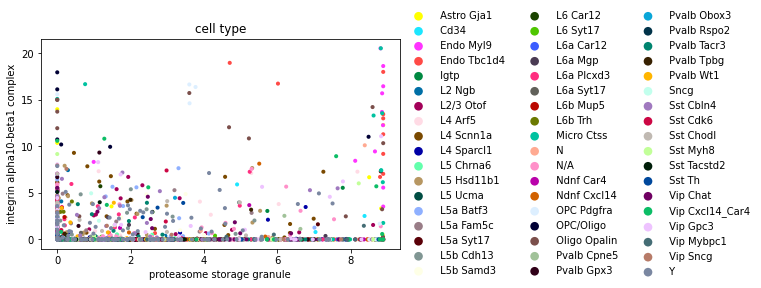

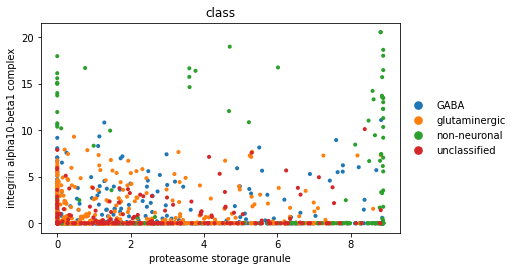

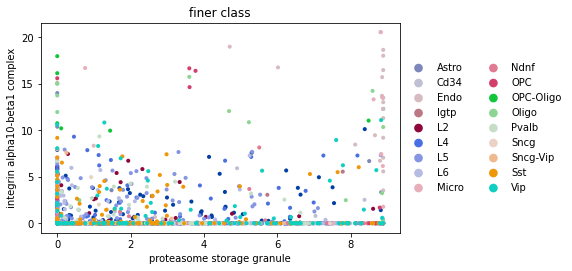

In [17]:
# plot against most variable axis
variable_axis = np.argsort(-np.var(embedded.X, axis = 0))

sc.pl.scatter(embedded, x = embedded.var_names[variable_axis[0]], y = embedded.var_names[variable_axis[1]], color = 'class')
sc.pl.scatter(embedded, x = embedded.var_names[variable_axis[0]], y = embedded.var_names[variable_axis[1]], color = 'finer_class')


In [18]:
# embed latent space
sc.pp.neighbors(embedded, use_rep='X')
sc.tl.umap(embedded)

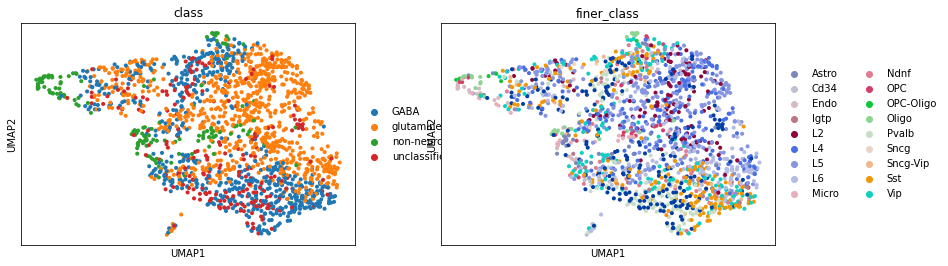

In [19]:
sc.pl.umap(embedded, color = ['class', 'finer_class'], alpha = 1)

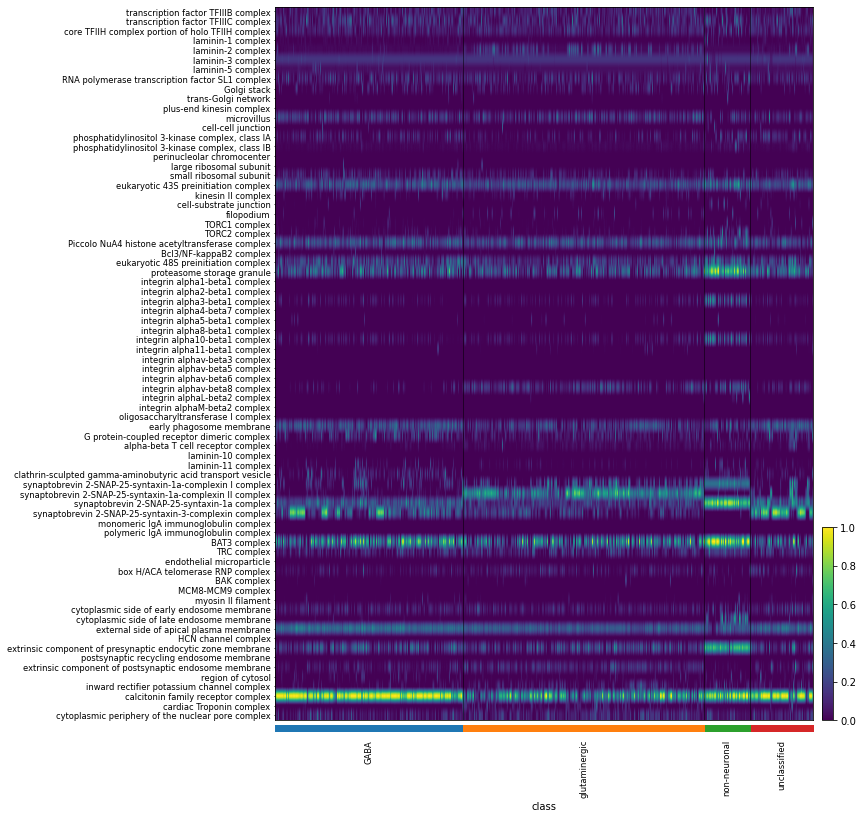

GridSpec(3, 3, height_ratios=[0, 13.32, 0.13], width_ratios=[10, 0, 0.2])

In [20]:
sc.pl.heatmap(embedded, var_names = embedded.var.index, show_gene_labels = True, swap_axes = True, standard_scale = 'var', groupby = 'class')


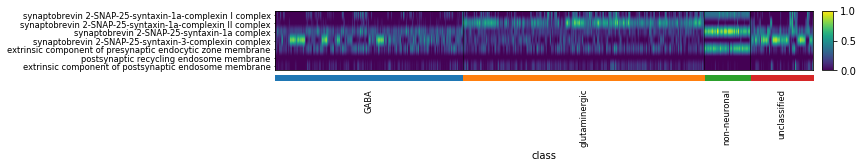

In [21]:
interested_terms = embedded.var.index[(embedded.var.index.str.contains('synap'))|(embedded.var.index.str.contains('neuro'))]
ax = sc.pl.heatmap(embedded, var_names = interested_terms, show_gene_labels = True, swap_axes = True, standard_scale = 'var', groupby = 'class')


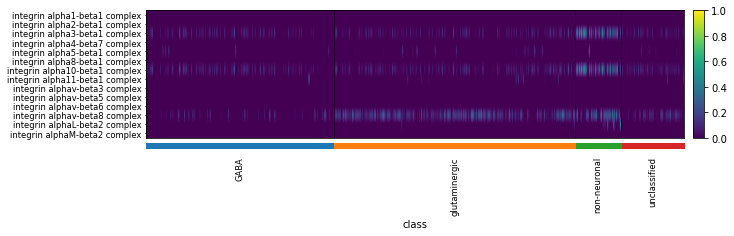

In [25]:
interested_terms = embedded.var.index[(embedded.var.index.str.contains('integrin'))]
ax = sc.pl.heatmap(embedded, var_names = interested_terms, show_gene_labels = True, swap_axes = True, standard_scale = 'var', groupby = 'class')


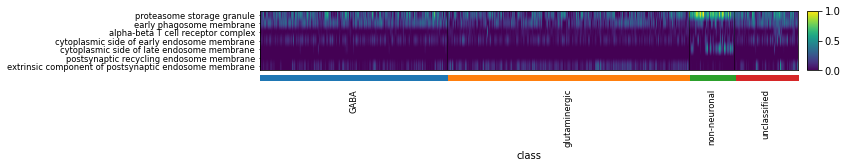

In [26]:
interested_terms = embedded.var.index[(embedded.var.index.str.contains('some'))|(embedded.var.index.str.contains('T cell'))]
ax = sc.pl.heatmap(embedded, var_names = interested_terms, show_gene_labels = True, swap_axes = True, standard_scale = 'var', groupby = 'class')
